## Face Mask Detection Module

### This will detect whether the person has worn the Face Mask in Real-Time.

In [1]:
# Importing the required libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Initialize the Learning rate for getting better accuracy from initial run.
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [5]:
# Setting up the directory where the images for the Dataset are and linking the dataset.
DIRECTORY = r"C:\Users\DHAVAL\PycharmProjects\AML_3406_1- Capstone Project\Face Mask Detection New\Face-Mask-Detection-master\dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [7]:
data = []
labels = []

In [8]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

c:\users\dhaval\appdata\local\programs\python\python38\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [9]:
# Performing one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [10]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [11]:
# Splitting the data into training and test sets
(X_train, X_test, y_train, y_test) = train_test_split(data, labels, test_size=0.30, stratify=labels, random_state=42)

In [12]:
# Data Augmentation using Image Generator
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, 
                         horizontal_flip=True, fill_mode="nearest")

In [13]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 8s 1us/step


In [14]:
# Head of the model will be placed on top of the the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [15]:
# this will be actual Head model we will train
model = Model(inputs=baseModel.input, outputs=headModel)

In [16]:
# loop over all layers in the base model and freeze them so they will "not" be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [19]:
# Compiling our model
print("=========================")
print("[INFO] Compiling model...")
print("=========================")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [21]:
# train the head of the network
print("=======================")
print("[INFO] Training Head...")
print("=======================")
H = model.fit(aug.flow(X_train, y_train, batch_size=BS), steps_per_epoch=len(X_train) // BS, validation_data=(X_test, y_test), 
              validation_steps=len(X_train) // BS, epochs=EPOCHS)

[INFO] Training Head...
Epoch 1/20
83/83 [==============================] - 186s 2s/step - loss: 0.4231 - accuracy: 0.8484 - val_loss: 0.1757 - val_accuracy: 0.9817
Epoch 2/20
83/83 [==============================] - 154s 2s/step - loss: 0.1606 - accuracy: 0.9645 - val_loss: 0.0950 - val_accuracy: 0.9809
Epoch 3/20
83/83 [==============================] - 138s 2s/step - loss: 0.1041 - accuracy: 0.9721 - val_loss: 0.0635 - val_accuracy: 0.9887
Epoch 4/20
83/83 [==============================] - 140s 2s/step - loss: 0.0849 - accuracy: 0.9759 - val_loss: 0.0529 - val_accuracy: 0.9887
Epoch 5/20
83/83 [==============================] - 137s 2s/step - loss: 0.0667 - accuracy: 0.9842 - val_loss: 0.0444 - val_accuracy: 0.9904
Epoch 6/20
83/83 [==============================] - 137s 2s/step - loss: 0.0594 - accuracy: 0.9842 - val_loss: 0.0402 - val_accuracy: 0.9913
Epoch 7/20
83/83 [==============================] - 137s 2s/step - loss: 0.0522 - accuracy: 0.9860 - val_loss: 0.0387 - val_accura

In [23]:
# Making Predictions on Testing Data
print("============================")
print("[INFO] evaluating network...")
print("============================")
predIdxs = model.predict(X_train, batch_size=BS)

[INFO] evaluating network...


In [24]:
# For each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [26]:
# Displaying the Classification Report in a suitable manner
print(classification_report(y_test.argmax(axis=1), predIdxs, target_names=lb.classes_))

ValueError: Found input variables with inconsistent numbers of samples: [1150, 2683]

In [28]:
# serialize the model to disk
print("====================================")
print("[INFO] Saving mask detector model...")
print("====================================")
model.save("mask_detector.model", save_format="h5")

[INFO] Saving mask detector model...


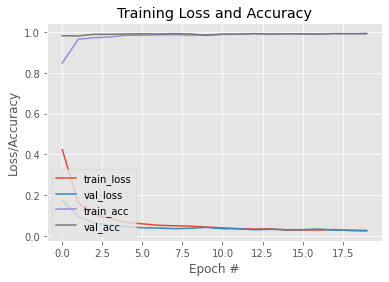

In [31]:
# Plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")